Libraries (don't change)

In [25]:
!pip -q install torchinfo

from dataclasses import dataclass
from typing import List, Callable, Optional, Tuple

import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchinfo import summary

from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
%matplotlib inline


Device (don't change)

In [26]:

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
use_amp = (DEVICE == "cuda")

print(f"Using device: {DEVICE}")
print(f"Mixed precision (AMP): {use_amp}")

Using device: cuda
Mixed precision (AMP): True


Data (don't change)

In [27]:

class DataManager:
    def __init__(self, dataset_class, root: str = "./data", val_fraction: float = 0.1,
                 batch_size: int = 32, seed: int = 42):
        self.dataset_class = dataset_class
        self.root = root
        self.val_fraction = val_fraction
        self.batch_size = batch_size
        self.seed = seed

        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1918,), (0.3483,))
        ])

    def get_loaders(self) -> Tuple[DataLoader, DataLoader, DataLoader]:
        full_train = self.dataset_class(root=self.root, train=True,
                                        download=True, transform=self.transform)
        test_ds = self.dataset_class(root=self.root, train=False,
                                     download=True, transform=self.transform)

        val_size = int(len(full_train) * self.val_fraction)
        train_size = len(full_train) - val_size

        generator = torch.Generator().manual_seed(self.seed)
        train_ds, val_ds = random_split(full_train, [train_size, val_size], generator=generator)

        train_loader = DataLoader(train_ds, batch_size=self.batch_size,
                                  shuffle=True, num_workers=2, pin_memory=True)
        val_loader   = DataLoader(val_ds,   batch_size=self.batch_size,
                                  shuffle=False, num_workers=2, pin_memory=True)
        test_loader  = DataLoader(test_ds,  batch_size=self.batch_size,
                                  shuffle=False, num_workers=2, pin_memory=True)

        print(f"Train: {len(train_ds)} | Val: {len(val_ds)} | Test: {len(test_ds)}")
        return train_loader, val_loader, test_loader

Configurations (don't change)

In [28]:

@dataclass
class LayerSpec:
    out_dim: int
    activation: Callable[[torch.Tensor], torch.Tensor] = F.relu
    dropout: float = 0.0
    batch_norm: bool = True
    weight_decay: float = 0.0

@dataclass
class ModelConfig:
    input_dim: Tuple[int, int, int] = (1, 28, 28)
    num_classes: int = 10
    layers: List[LayerSpec] = None

@dataclass
class TrainConfig:
    batch_size: int = 64
    epochs: int = 100
    lr: float = 1e-4
    patience: int = 15
    min_delta: float = 1e-4
    val_fraction: float = 0.1
    seed: int = 42


Model

In [29]:

class MLPFromConfig(nn.Module):
    def __init__(self, config: ModelConfig):
        super().__init__()
        flat_dim = config.input_dim[0] * config.input_dim[1] * config.input_dim[2]
        self.layers_specs = config.layers
        layers = []
        prev_dim = flat_dim

        for i, spec in enumerate(config.layers):
            linear = nn.Linear(prev_dim, spec.out_dim)

            layers.append(linear)
            if spec.batch_norm:
                layers.append(nn.BatchNorm1d(spec.out_dim))
            if spec.dropout > 0:
                layers.append(nn.Dropout(spec.dropout))
            layers.append(spec.activation())
            prev_dim = spec.out_dim

        # Final classifier layer
        self.final_linear = nn.Linear(prev_dim, config.num_classes)
        layers.append(self.final_linear)

        self.net = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.view(x.size(0), -1)
        return self.net(x)

    def get_layer_params(self):
        param_groups = []
        for i, spec in enumerate(self.layers_specs):
            linear_layer = self.net[i * (4 if spec.batch_norm or spec.dropout > 0 else 3)]
            pass
        return self.layers_specs

Early Stopping (don't change)

In [30]:

class EarlyStopping:
    def __init__(self, patience: int = 10, min_delta: float = 1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.should_stop = False

    def __call__(self, val_loss: float) -> bool:
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.should_stop = True
        return self.should_stop

Trainer (don't change)

In [31]:

class Trainer:
    def __init__(self, model: nn.Module, config: TrainConfig):
        self.model = model.to(DEVICE)
        self.config = config
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = self._build_optimizer()
        self.scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
        self.early_stopping = EarlyStopping(patience=config.patience,
                                            min_delta=config.min_delta)

        self.history = {"train_loss": [], "train_acc": [],
                        "val_loss": [], "val_acc": []}

    def _build_optimizer(self):

        # Collect all Linear layers in the order they appear
        linear_layers = []
        for name, module in self.model.named_modules():
            if isinstance(module, nn.Linear):
                linear_layers.append((name, module))

        param_groups = []

        for i, spec in enumerate(self.model.layers_specs):
            name, layer = linear_layers[i]
            param_groups.append({
                'params': layer.parameters(),
                'weight_decay': spec.weight_decay
            })

        final_name, final_layer = linear_layers[-1]
        param_groups.append({
            'params': final_layer.parameters(),
            'weight_decay': 0.0
        })

        return torch.optim.SGD(param_groups, momentum=0.9, nesterov=True, lr=self.config.lr)

    def _train_epoch(self, loader: DataLoader):
        self.model.train()
        total_loss = 0.0
        correct = 0
        total = 0

        for data, target in loader:
            data, target = data.to(DEVICE), target.to(DEVICE)

            self.optimizer.zero_grad()
            with torch.cuda.amp.autocast(enabled=use_amp):
                output = self.model(data)
                loss = self.criterion(output, target)

            self.scaler.scale(loss).backward()
            self.scaler.step(self.optimizer)
            self.scaler.update()

            total_loss += loss.item() * data.size(0)
            correct += (output.argmax(1) == target).sum().item()
            total += data.size(0)

        return total_loss / total, correct / total

    @torch.no_grad()
    def _eval_epoch(self, loader: DataLoader):
        self.model.eval()
        total_loss = 0.0
        correct = 0
        total = 0

        for data, target in loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            with torch.cuda.amp.autocast(enabled=use_amp):
                output = self.model(data)
                loss = self.criterion(output, target)

            total_loss += loss.item() * data.size(0)
            correct += (output.argmax(1) == target).sum().item()
            total += data.size(0)

        return total_loss / total, correct / total

    def fit(self, train_loader: DataLoader, val_loader: DataLoader):
        print("🚀 Starting training...\n")
        for epoch in range(1, self.config.epochs + 1):
            train_loss, train_acc = self._train_epoch(train_loader)
            val_loss, val_acc     = self._eval_epoch(val_loader)

            self.history["train_loss"].append(train_loss)
            self.history["train_acc"].append(train_acc)
            self.history["val_loss"].append(val_loss)
            self.history["val_acc"].append(val_acc)

            print(f"Epoch {epoch:3d} | "
                  f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
                  f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

            if self.early_stopping(val_loss):
                print(f"\n🛑 Early stopping triggered at epoch {epoch}")
                break

        print("\n✅ Training complete!")

    @torch.no_grad()
    def evaluate(self, loader: DataLoader):
        return self._eval_epoch(loader)

    @torch.no_grad()
    def predict_all(self, loader: DataLoader):
        self.model.eval()
        all_preds, all_targets = [], []
        for x, y in loader:
            x = x.to(DEVICE, non_blocking=True)
            logits = self.model(x)
            preds = logits.argmax(dim=1).cpu().numpy()
            all_preds.append(preds)
            all_targets.append(y.numpy())
        return np.concatenate(all_preds), np.concatenate(all_targets)


    def save(self, path: str = "mlp_best.pt"):
        torch.save(self.model.state_dict(), path)
        print(f"💾 Model saved to {path}")



Run (do change)

In [32]:
train_cfg = TrainConfig(
    batch_size=128,
    epochs=100,
    lr=1e-4,
    patience=5,
    val_fraction=0.1
)

data_mgr = DataManager(
    dataset_class=datasets.KMNIST,
    val_fraction=train_cfg.val_fraction,
    batch_size=train_cfg.batch_size,
    seed=train_cfg.seed
)
train_loader, val_loader, test_loader = data_mgr.get_loaders()

model_cfg = ModelConfig(
    layers=[
        LayerSpec(out_dim=512, dropout=0.2, batch_norm=True,  activation=nn.ReLU, weight_decay=1e-4),
        LayerSpec(out_dim=256, dropout=0.2, batch_norm=True,  activation=nn.ReLU, weight_decay=1e-4),
        LayerSpec(out_dim=128, dropout=0.1, batch_norm=True,  activation=nn.ReLU, weight_decay=1e-4),
    ]
)


# Build model
model = MLPFromConfig(model_cfg)
print(summary(model, input_size=(1, 28, 28)))

trainer = Trainer(model, train_cfg)
trainer.fit(train_loader, val_loader)
trainer.save("mlp_colab_best.pt")


Train: 54000 | Val: 6000 | Test: 10000
Layer (type:depth-idx)                   Output Shape              Param #
MLPFromConfig                            [1, 10]                   --
├─Sequential: 1-1                        [1, 10]                   --
│    └─Linear: 2-1                       [1, 512]                  401,920
│    └─BatchNorm1d: 2-2                  [1, 512]                  1,024
│    └─Dropout: 2-3                      [1, 512]                  --
│    └─ReLU: 2-4                         [1, 512]                  --
│    └─Linear: 2-5                       [1, 256]                  131,328
│    └─BatchNorm1d: 2-6                  [1, 256]                  512
│    └─Dropout: 2-7                      [1, 256]                  --
│    └─ReLU: 2-8                         [1, 256]                  --
│    └─Linear: 2-9                       [1, 128]                  32,896
│    └─BatchNorm1d: 2-10                 [1, 128]                  256
│    └─Dropout: 2-11       

/tmp/ipython-input-2705984033.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
/tmp/ipython-input-2705984033.py:49: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipython-input-2705984033.py:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Epoch   1 | Train Loss: 2.0860 Acc: 0.2949 | Val Loss: 1.7508 Acc: 0.6175
Epoch   2 | Train Loss: 1.6163 Acc: 0.5999 | Val Loss: 1.3806 Acc: 0.7167
Epoch   3 | Train Loss: 1.3300 Acc: 0.6872 | Val Loss: 1.1494 Acc: 0.7445
Epoch   4 | Train Loss: 1.1484 Acc: 0.7237 | Val Loss: 1.0010 Acc: 0.7652
Epoch   5 | Train Loss: 1.0175 Acc: 0.7468 | Val Loss: 0.8894 Acc: 0.7822
Epoch   6 | Train Loss: 0.9236 Acc: 0.7639 | Val Loss: 0.8063 Acc: 0.7952
Epoch   7 | Train Loss: 0.8498 Acc: 0.7805 | Val Loss: 0.7437 Acc: 0.8067
Epoch   8 | Train Loss: 0.7912 Acc: 0.7898 | Val Loss: 0.6876 Acc: 0.8178
Epoch   9 | Train Loss: 0.7437 Acc: 0.8022 | Val Loss: 0.6427 Acc: 0.8280
Epoch  10 | Train Loss: 0.7027 Acc: 0.8099 | Val Loss: 0.6063 Acc: 0.8335
Epoch  11 | Train Loss: 0.6650 Acc: 0.8188 | Val Loss: 0.5759 Acc: 0.8425
Epoch  12 | Train Loss: 0.6347 Acc: 0.8269 | Val Loss: 0.5510 Acc: 0.8503
Epoch  13 | Train Loss: 0.6112 Acc: 0.8330 | Val Loss: 0.5249 Acc: 0.8560
Epoch  14 | Train Loss: 0.5841 Acc: 0.

Visuazize the train


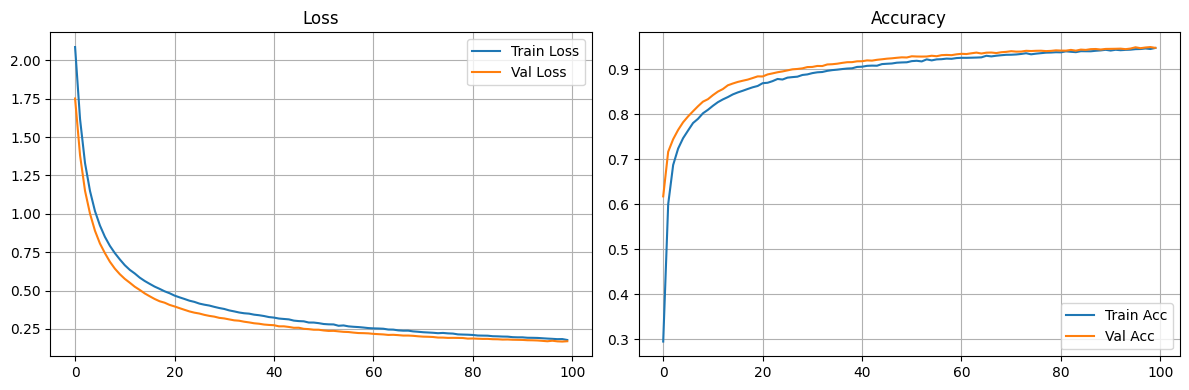

In [33]:

history = trainer.history

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"],   label="Val Loss")
plt.title("Loss")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history["train_acc"], label="Train Acc")
plt.plot(history["val_acc"],   label="Val Acc")
plt.title("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()




Visualized the test (do change)

/tmp/ipython-input-2705984033.py:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


🏆 Test Loss: 0.3949 | Test Accuracy: 0.8780


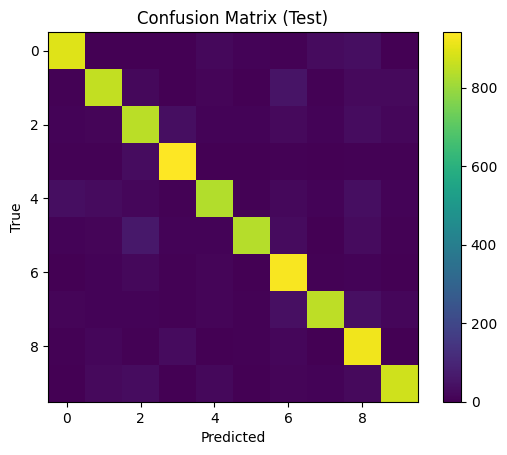

Classification report (Test):
              precision    recall  f1-score   support

           0     0.9086    0.8950    0.9018      1000
           1     0.8744    0.8560    0.8651      1000
           2     0.8115    0.8440    0.8275      1000
           3     0.9101    0.9410    0.9253      1000
           4     0.8920    0.8340    0.8620      1000
           5     0.9566    0.8380    0.8934      1000
           6     0.8246    0.9310    0.8746      1000
           7     0.9218    0.8490    0.8839      1000
           8     0.8005    0.9190    0.8557      1000
           9     0.9150    0.8720    0.8930      1000

    accuracy                         0.8779     10000
   macro avg     0.8815    0.8779    0.8782     10000
weighted avg     0.8815    0.8779    0.8782     10000



In [34]:
# entire test result
test_loss, test_acc = trainer.evaluate(test_loader)
print(f"🏆 Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")

# predictions
preds, targets = trainer.predict_all(test_loader)

# confusion matrix
cm = confusion_matrix(targets, preds)
plt.figure()
plt.imshow(cm)
plt.title("Confusion Matrix (Test)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.show()


# per-class report
print("Classification report (Test):")
print(classification_report(targets, preds, digits=4))

